# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек и модулей

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import t

pd.options.mode.chained_assignment = None

#сохраним нужные данные в константы
WELL_NUM_RESEARCH = 500
WELL_NUM = 200
BUDGET_LIM = 10**10
BARREL_PRICE = 450
RISK_TRESHOLD = 0.025

### Загрузка и первичный осмотр данных

In [12]:
data = [pd.read_csv('/datasets/geo_data_0.csv'), pd.read_csv('/datasets/geo_data_1.csv'), pd.read_csv('/datasets/geo_data_2.csv')]
for dataset in data:
    display(dataset.sample(3))
    print('Дубликатов в данных:', dataset.duplicated().sum())
    print('Пропусков в данных:', dataset.isna().sum())

,id,f0,f1,f2,product
42214,8wd0D,0.618166,0.778863,3.719244,52.154437
521,qa8qq,-0.538434,0.943164,4.455122,78.403915
35412,mAxKm,-0.767276,0.782809,7.502054,151.794298


Дубликатов в данных: 0
Пропусков в данных: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,id,f0,f1,f2,product
84766,qrwW9,13.782957,-8.663393,2.000847,53.906522
79816,AyNTJ,-15.124924,-10.186379,5.001266,137.945408
32832,odVIP,13.583417,-3.502521,3.005498,80.859783


Дубликатов в данных: 0
Пропусков в данных: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,id,f0,f1,f2,product
57203,QRAfH,0.698773,2.122086,5.330025,158.694066
34727,sxFp7,-0.970851,-0.198292,7.214525,131.947962
20902,Bygah,-1.377428,2.355767,9.496089,188.470534


Дубликатов в данных: 0
Пропусков в данных: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


<u>Промежуточный вывод:</u> дубликатов и пропусков не обнаружено

### Проверка данных на аномалии

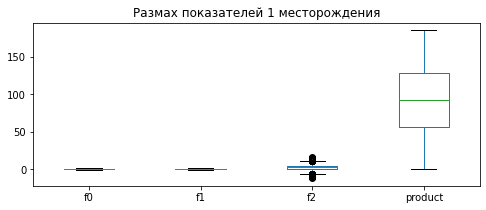

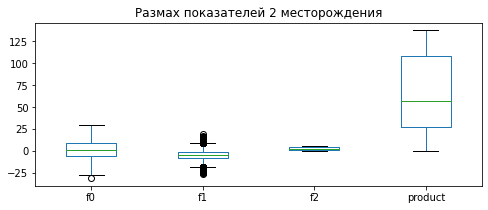

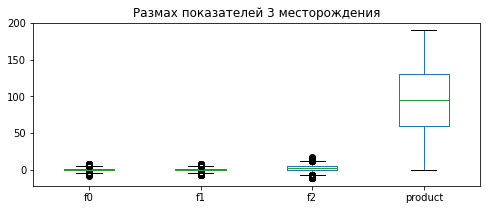

In [13]:
count = 1
for dataset in data:
    dataset.plot(kind = 'box', figsize=(8,3))
    plt.title(f'Размах показателей {count} месторождения')
    count+=1

<u>Промежуточный вывод:</u> "ящики с усами" помогают увидеть сходство между 1 и 3 месторождением и явные отличия второго, ввиду меньшего размаха в плане кол-ва баррелей, а также отсутствия выборосов в показателе f2. Также сами "ящики" в случае второго месторождения шире, след-но диапазон "нормальных" значений больше. Выбросы в случае месторождений 1 и 3 симметричны сверху и снизу.

### Корреляционный анализ данных

In [14]:
for dataset in data:
    display(dataset.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


<u>Промежуточный вывод:</u> гипотеза подтверждается - месторождения 1 и 3 действительно похожи по корреляционным показателям. Месторождение 2 имеет почти идеальную положительную корреляцию между показателем f2 и кол-вом баррелей нефти. Скорее всего, именно в случае этого месторождения модель предсказаний будет работать лучше всего.

Также очевиден тот факт, что сильнее всего с кол-вом баррелей нефти в месторождении связан именно показатель f2.

### Вывод по этапу:
- данные соответствуют критериям clean data (выбросы не убираем, тк они симметричны и поэтому, скорее всего, нейтрализуют друг друга)
- подтверждается гипотеза о схожести 1 и 3 месторождений
- 2 месторождение сильно отличается от двух других
- в случае месторождения 2 обнаружена очень сильная положительная корреляция показателя f2 и кол-вом баррелей нефти
- с кол-вом баррелей нефти сильнее всего связан показатель f2
    

## Обучение и проверка модели

### Разбивка данных на фичи и таргет

In [15]:
#создадим пустые списки для ЦП и features
target_list = []
features_list = []
#циклом сохраним ЦП и features в нужные списки
for dataset in data:
    target_list.append(dataset['product'])
    features_list.append(dataset.drop(['product', 'id'], axis = 1))

#проверим кол-во списков в списках    
print('Количество таргетов в списке:', len(target_list))
print('Количество фич в списке:', len(features_list))

#проверим features
for feature in features_list:
    display(feature.sample(3))

#проверим target
for target in target_list:
    display(target.sample(3))

Количество таргетов в списке: 3
Количество фич в списке: 3


,f0,f1,f2
46348,1.094542,0.072682,9.797778
98106,0.944224,0.455562,7.529533
59996,0.642145,-0.378765,2.062776


,f0,f1,f2
20750,6.762048,-7.991576,0.995634
90688,-21.591349,-6.309025,3.992360
14238,-3.032344,-12.474891,3.000128


,f0,f1,f2
58179,-0.568845,-0.867067,9.160006
47686,1.430719,0.004242,0.558422
5506,3.341717,0.615271,3.388700


48445    138.390533
93893    107.069011
30720    110.100707
Name: product, dtype: float64

72413    107.813044
3068     107.813044
58944    110.992147
Name: product, dtype: float64

16683    115.795886
96675     28.403768
91243    136.874004
Name: product, dtype: float64

### Разделение данных на обучающую и валидационную выборки

In [16]:
features_train_list = []
features_valid_list = []
target_train_list = []
target_valid_list = []
for i in range(len(features_list)):
    features_train, features_valid, target_train, target_valid = train_test_split(features_list[i], target_list[i],
                                                                                  test_size = 0.25, random_state = 42) 
    features_train_list.append(features_train)
    features_valid_list.append(features_valid)
    target_train_list.append(target_train)
    target_valid_list.append(target_valid)


# проверим соотношение данных
print([len(x) for x in features_train_list])
print([len(x) for x in features_valid_list])
print([len(x) for x in target_train_list])
print([len(x) for x in  target_valid_list])

[75000, 75000, 75000]
[25000, 25000, 25000]
[75000, 75000, 75000]
[25000, 25000, 25000]


### Обучение линейной регрессии на обучающих выборках

In [17]:
pred_results = []
predictions_list = []
model = LinearRegression()
for i in range(len(features_list)):
    model.fit(features_train_list[i], target_train_list[i])
    predictions = model.predict(features_valid_list[i])
    predictions_list.append(predictions)
    rmse = (mean_squared_error(target_valid_list[i].values, predictions))**0.5
    print('Показатель RMSE равен:', rmse)
    print('Показатель качества модели составляет:', r2_score(target_valid_list[i].values, predictions))
    print('Среднее предсказанное значение составляет:', predictions.mean())
    pred_model = [rmse, r2_score(target_valid_list[i].values, predictions), predictions.mean()]
    pred_results.append(pred_model)
    print()

Показатель RMSE равен: 37.75660035026169
Показатель качества модели составляет: 0.2728287328173471
Среднее предсказанное значение составляет: 92.39879990657768

Показатель RMSE равен: 0.890280100102884
Показатель качества модели составляет: 0.9996245232002449
Среднее предсказанное значение составляет: 68.71287803913762

Показатель RMSE равен: 40.145872311342174
Показатель качества модели составляет: 0.19634705977280487
Среднее предсказанное значение составляет: 94.77102387765939



In [18]:
#соберем полученные данные в одну таблицу
joint_data = pd.DataFrame(index = [1,2,3], columns = ['RMSE', 'R2_score', 'Предсказанное зн-е'],
            data = pred_results)
display(joint_data)

,RMSE,R2_score,Предсказанное зн-е
1,37.756600,0.272829,92.398800
2,0.890280,0.999625,68.712878
3,40.145872,0.196347,94.771024


<b>Вывод по этапу:</b> гипотеза все еще подтверждается: среднее предсказание по запасам почти совпадает в случае 1 и 3 модели, но качество модели оставляет желать лучшего. Зато очень высокое качество модели в случае 2 месторождения, но там предсказание по запасам ниже примерно на треть.

## Подготовка к расчёту прибыли

### Расчет предельной стоимости разработки и необходимого запаса сырья

In [19]:
#рассчитаем предельную стоимость разработки скважины
well_dev_cost = BUDGET_LIM / WELL_NUM
print('Предельная стоимость разработки одной скважины составляет:', well_dev_cost)

#рассчитаем необходимый запас сырья в тыс., чтобы не уйти в минус
min_barrel_per_well = ceil(well_dev_cost / (BARREL_PRICE * 1000))

print('Минимальный запас сырья в скважине должен составлять', min_barrel_per_well,
      'тысяч баррелей')

Предельная стоимость разработки одной скважины составляет: 50000000.0
Минимальный запас сырья в скважине должен составлять 112 тысяч баррелей


<b>Сравним полученный объем сырья со средним по регионам</b>

In [20]:
#вызовем таблицу joint_data
joint_data

,RMSE,R2_score,Предсказанное зн-е
1,37.756600,0.272829,92.398800
2,0.890280,0.999625,68.712878
3,40.145872,0.196347,94.771024


<b>Вывод по этапу:</b> судя по предсказаниям модели, ни в одном из регионов в среднем не наблюдается порогового значения. Однако в 1 и 3 регионе разница не столь большая по сравнению со 2 - там значение едва ли превышает половину от требуемого. Тем не менее, мы разрабатываем всего 200 скважин, а не все, поэтому не исключено, что есть "плодовитые" скважины, а есть те, где запасы почти на нуле. Поэтому задача состоит в том, чтобы найти среди скважин наиболее прибыльные по всем трем регионам.

## Расчёт прибыли и рисков 

### Создание ф-ции расчета прибыли

In [21]:
def predicted_revenue(target, predictions, count):
    top_wells = pd.Series(predictions).sort_values(ascending=False).head(count)
    predicted_profit = (target.loc[top_wells.index] * 1000 * BARREL_PRICE).sum()
    return predicted_profit - (well_dev_cost * count)

count = 1
for i in range(len(target_valid_list)):
    print(f'Предполагаемая прибыль по {count} месторождению составляет', 
          predicted_revenue(target_valid_list[i].reset_index(drop = True), predictions_list[i], WELL_NUM))
    count+=1

Предполагаемая прибыль по 1 месторождению составляет 3359141114.462181
Предполагаемая прибыль по 2 месторождению составляет 2415086696.681507
Предполагаемая прибыль по 3 месторождению составляет 2598571759.374111


### Применение bootstrap для нахождения распределения прибыли

In [23]:
random_state = np.random.RandomState(seed = 42)
bootstrap_samples = 1000
revenues = []

for i in range(len(target_valid_list)):
    revenue = []
    for j in range(bootstrap_samples):
        target_subsample = target_valid_list[i].reset_index(drop= True).sample(WELL_NUM_RESEARCH, 
                                                                         replace=True,
                                                                         random_state=random_state)
        predictions_subsample = pd.Series(predictions_list[i]).loc[target_subsample.index]
        revenue.append(predicted_revenue(target_subsample, predictions_subsample, WELL_NUM)) 

    revenues.append(revenue)    

### Визуализация данных бутстрепа

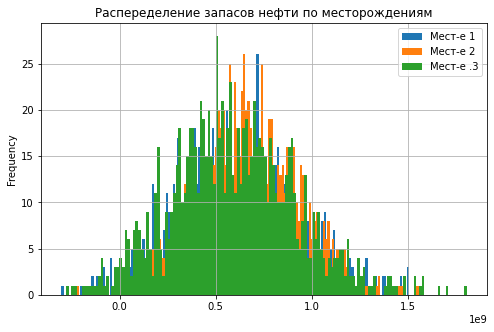

In [43]:
for revenue in revenues:
    pd.Series(revenue).plot(kind = 'hist', legend = True, figsize = (8,5), bins = 150, grid = True)
    plt.title('Распеределение запасов нефти по месторождениям')
    plt.legend(['Мест-е 1', 'Мест-е 2', 'Мест-е .3'])

<u>Промежуточный вывод:</u> как видно, распределение прибыли нормальное во всех случаях, средних значений в случае 2 месторождения больше. У 3 месторождения длиннее хвосты в сторону больших значений.

### Расчет средней прибыли, 95%-ого доверительного интервала и риска убытков

In [58]:
#рассчитаем среднюю прибыль по месторождениям
estimated_profit = pd.DataFrame(index = [1,2,3], columns = ['Estimated Profit'],
                                data = [pd.Series(x).mean() for x in revenues])
display(estimated_profit)

,Estimated Profit
1,6.061226e+08
2,6.624132e+08
3,5.920520e+08


In [95]:
#рассчитаем 95% доверительный интервал
CONF_INTERVAL = 0.05
lower = (1 - CONF_INTERVAL) / 2
upper = (1 + CONF_INTERVAL) / 2
intervals = []
deviation = []

for revenue in revenues:
    intervals.append([int(pd.Series(revenue).quantile(lower)), int(pd.Series(revenue).quantile(upper))])
    deviation.append([int(pd.Series(revenue).std())])

#соберем рез-ты в таблицу
conf_intervals = pd.DataFrame(index = ['Confidence Intervals', 'Standard Deviation'],
                              columns = [1,2,3], data = [intervals, deviation])
display(conf_intervals)

,1,2,3
Confidence Intervals,"[583497202, 623025136]","[637899068, 666706921]","[557285060, 593923803]"
Standard Deviation,[312885587],[268161964],[323852767]


In [89]:
#учтем риск убытков
loss = []
for revenue in revenues:
    loss.append(sum([x for x in revenue if x<0]))

potential_loss = pd.DataFrame(index = [1,2,3], columns = ['Potential Loss'], data = loss)
display(potential_loss)

,Potential Loss
1,-2.389651e+09
2,-3.400096e+08
3,-2.611455e+09


In [111]:
# сведем данные в единую таблицу
total_table = pd.DataFrame(index = ['Месторождение 1', 'Месторождение 2', 'Месторождение 3'],
                          columns = ['Ожидаемая прибыль', 'Доверительный интервал', 'Убытки'])
total_table['Ожидаемая прибыль'] = estimated_profit.values
total_table['Убытки'] = potential_loss.values
total_table['Доверительный интервал'] = list(conf_intervals.iloc[0])
display(total_table)

,Ожидаемая прибыль,Доверительный интервал,Убытки
Месторождение 1,6.061226e+08,"[583497202, 623025136]",-2.389651e+09
Месторождение 2,6.624132e+08,"[637899068, 666706921]",-3.400096e+08
Месторождение 3,5.920520e+08,"[557285060, 593923803]",-2.611455e+09


### Вывод:
- первое месторождение характеризуется средней доходностью и широким доверительным интервалом. Убытки на нем наименьшие относительно других месторождений.
- второе месторождение характеризуется самой высокой доходностью и узким доверительым интервалом. Даже бОльшие убытки не умаляют его прибыльности.
- третье месторождение характеризуется самой низкой доходностью и широким доверительным интервалом. Убыточность средняя.

По результатам, я бы однозначно рекомендовала вести разработки в месторождении номер 2 ввиду:
- точных предсказаний модели (99% правильных ответов)
- самой высокой прибыли месторождения
- узкого доверительного интвервала, делающего предсказания модели надежными

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован